In [4]:
import pandas as pd
import numpy as np
import scanpy as sc
import squidpy as sq
import anndata
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import r_regression
from sklearn.metrics import f1_score, precision_score, accuracy_score
from tqdm import tqdm
from plotnine import *
import matplotlib.pyplot as plt

## Build a toy model from pytorch for a preprocessed st dataset.

In [5]:
adata = sq.datasets.seqfish()
adata

AnnData object with n_obs × n_vars = 19416 × 351
    obs: 'Area', 'celltype_mapped_refined'
    uns: 'celltype_mapped_refined_colors'
    obsm: 'X_umap', 'spatial'

In [6]:
adata.obs["celltype_mapped_refined"].value_counts()

celltype_mapped_refined
Forebrain/Midbrain/Hindbrain      3704
Spinal cord                       2620
Low quality                       1645
Gut tube                          1464
Lateral plate mesoderm            1243
Splanchnic mesoderm               1138
Endothelium                        953
Neural crest                       912
Surface ectoderm                   801
Cardiomyocytes                     737
Haematoendothelial progenitors     637
Intermediate mesoderm              623
Mixed mesenchymal mesoderm         541
Cranial mesoderm                   528
Dermomyotome                       523
Presomitic mesoderm                458
Erythroid                          300
Definitive endoderm                213
Anterior somitic tissues           112
NMP                                109
Sclerotome                          78
Allantois                           77
Name: count, dtype: int64

We have 22 different categories, one with low quality which I will filter out for now. Let's first load the data to be a binary classifier brain/not brain. 

In [7]:
adata = adata[adata.obs["celltype_mapped_refined"] != "Low quality"]

### Quick look into correlations between gene expression and each of the celltypes

In [8]:
celltypes = list(adata.obs["celltype_mapped_refined"].unique())
celltype_onehot = pd.DataFrame(
    [np.where(adata.obs["celltype_mapped_refined"] == ct, [1., ], [0., ]) for ct in celltypes],
    index=celltypes
).T 
df_adata = adata.to_df()

pearsons = [
    r_regression(df_adata, celltype_onehot.loc[:, ct])
    for ct in celltypes
]
pearsons = pd.DataFrame(pearsons, index=celltypes).T
pearsons


,Lateral plate mesoderm,Erythroid,Allantois,Gut tube,Endothelium,Haematoendothelial progenitors,Intermediate mesoderm,Mixed mesenchymal mesoderm,Spinal cord,Neural crest,...,Forebrain/Midbrain/Hindbrain,Cranial mesoderm,Surface ectoderm,Definitive endoderm,NMP,Anterior somitic tissues,Presomitic mesoderm,Dermomyotome,Cardiomyocytes,Sclerotome
0,-0.013273,-0.019907,-0.017527,-0.035381,0.029175,0.020059,-0.006821,-0.017656,0.007853,0.013594,...,0.071538,-0.029880,0.003708,-0.011351,0.015763,-0.002442,-0.025963,0.014458,-0.030130,-0.006230
1,-0.015188,0.455724,-0.006368,-0.033260,0.011812,0.028043,-0.013905,0.010541,-0.032495,-0.024408,...,-0.034608,-0.034768,0.023829,-0.001454,-0.014260,-0.009939,-0.013805,-0.001351,-0.022888,-0.003098
2,0.039362,-0.026499,-0.012349,-0.012532,0.049056,0.024108,0.001054,-0.018767,-0.000913,0.009282,...,-0.043156,-0.005754,0.011972,-0.017484,0.018013,0.003340,0.000720,0.057432,-0.042306,-0.013942
3,0.001441,-0.027990,-0.008743,0.004906,0.026998,0.037108,-0.004618,0.001267,-0.088938,0.019465,...,0.015973,0.023810,0.038293,0.012788,-0.008554,0.013238,-0.034011,-0.009779,0.009748,0.001263
4,0.013890,-0.020913,-0.013617,-0.021282,0.016783,0.057611,0.007532,-0.001815,-0.002366,0.076139,...,-0.060131,-0.013973,0.037394,-0.008009,0.012520,0.004081,-0.000671,0.015828,-0.018770,0.003911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,-0.008378,-0.031429,-0.017713,-0.049106,0.023416,0.040836,-0.000427,-0.019741,0.007778,0.030623,...,-0.027667,-0.014475,0.040641,-0.000641,0.003099,0.007007,0.040792,0.030926,-0.026409,0.013154
347,0.019845,-0.036471,-0.017505,0.047526,-0.008987,-0.014002,-0.044232,-0.028116,-0.049225,0.044540,...,-0.003951,0.043214,0.004438,0.007001,0.002761,0.000660,0.016706,-0.009517,-0.030576,-0.003363
348,0.042534,-0.061370,-0.016138,0.058646,-0.028428,0.020591,0.005236,-0.005943,-0.033609,0.017589,...,-0.070780,-0.010400,0.044423,0.002264,0.019253,-0.011912,0.033269,0.010870,-0.015390,-0.012326
349,0.129442,-0.053548,0.000587,-0.016566,0.156320,0.104922,0.017614,0.049284,-0.160471,0.028053,...,-0.162825,0.056130,-0.020476,-0.001876,-0.007803,0.015361,-0.015514,0.023853,0.021036,0.003399


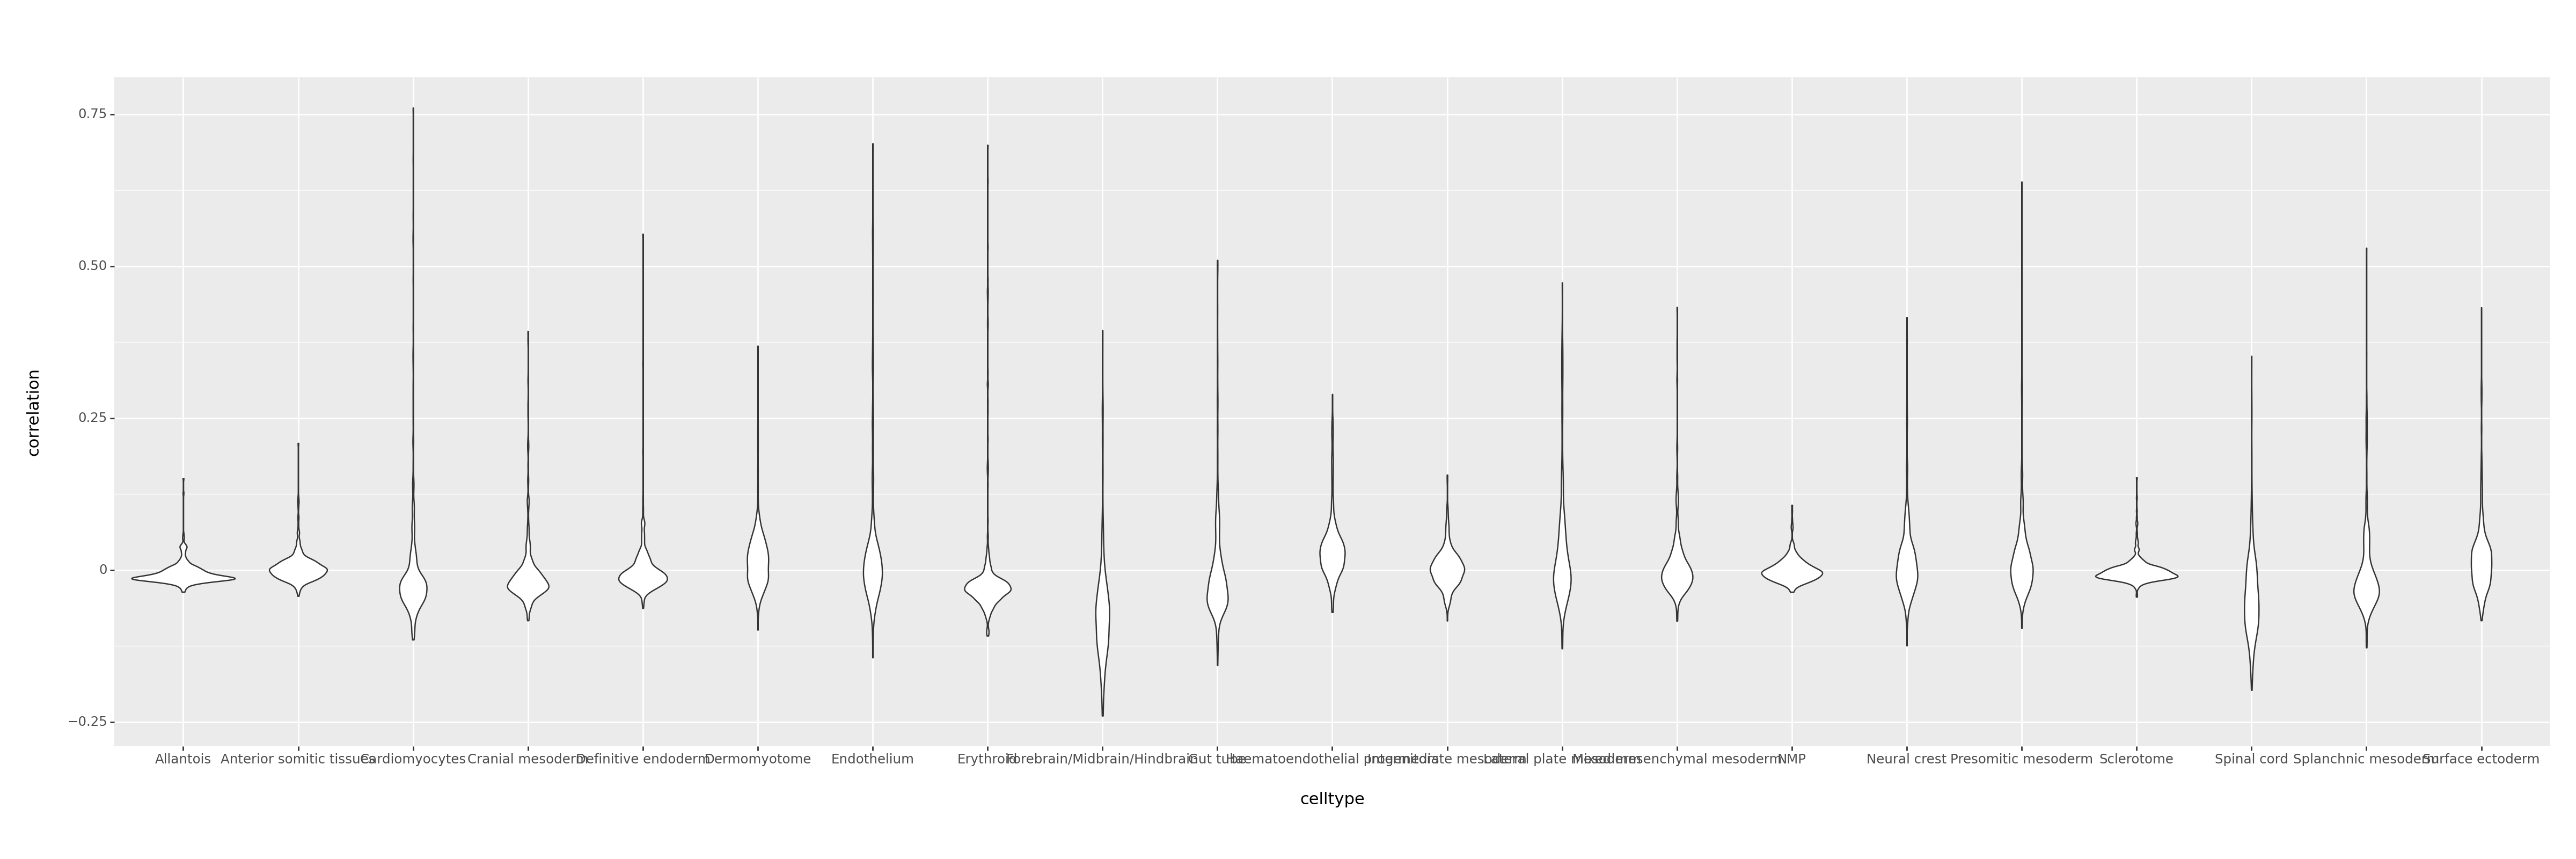

In [9]:
plot_df = pearsons.melt(var_name="celltype", value_name="correlation")
plot = (
    ggplot(plot_df, aes("celltype", "correlation")) +
    geom_violin(plot_df) +
    theme(figure_size=(24, 8)) +
    ggtitle("Distribution of Pearson Correlations between genes and celltype")
)
print(plot)

==> Many of the cell types have a few genes that are very highly correlated to it, but the bulk of genes is uncorrelated/negatively correlated.

In [10]:
frame = pd.concat((adata.to_df(), adata.obs["celltype_mapped_refined"]), axis=1)
target = np.where(
    frame["celltype_mapped_refined"] == "Forebrain/Midbrain/Hindbrain",
    [1,], [0,]
)
frame = frame.drop(columns="celltype_mapped_refined")
frame.shape, target.shape

((17771, 351), (17771,))

In [11]:
((frame["T"] > 0).astype(float) == target).sum() / len(frame)

0.660626863991897

The "T" column explains 66% of the data. Maybe it is not a gene?

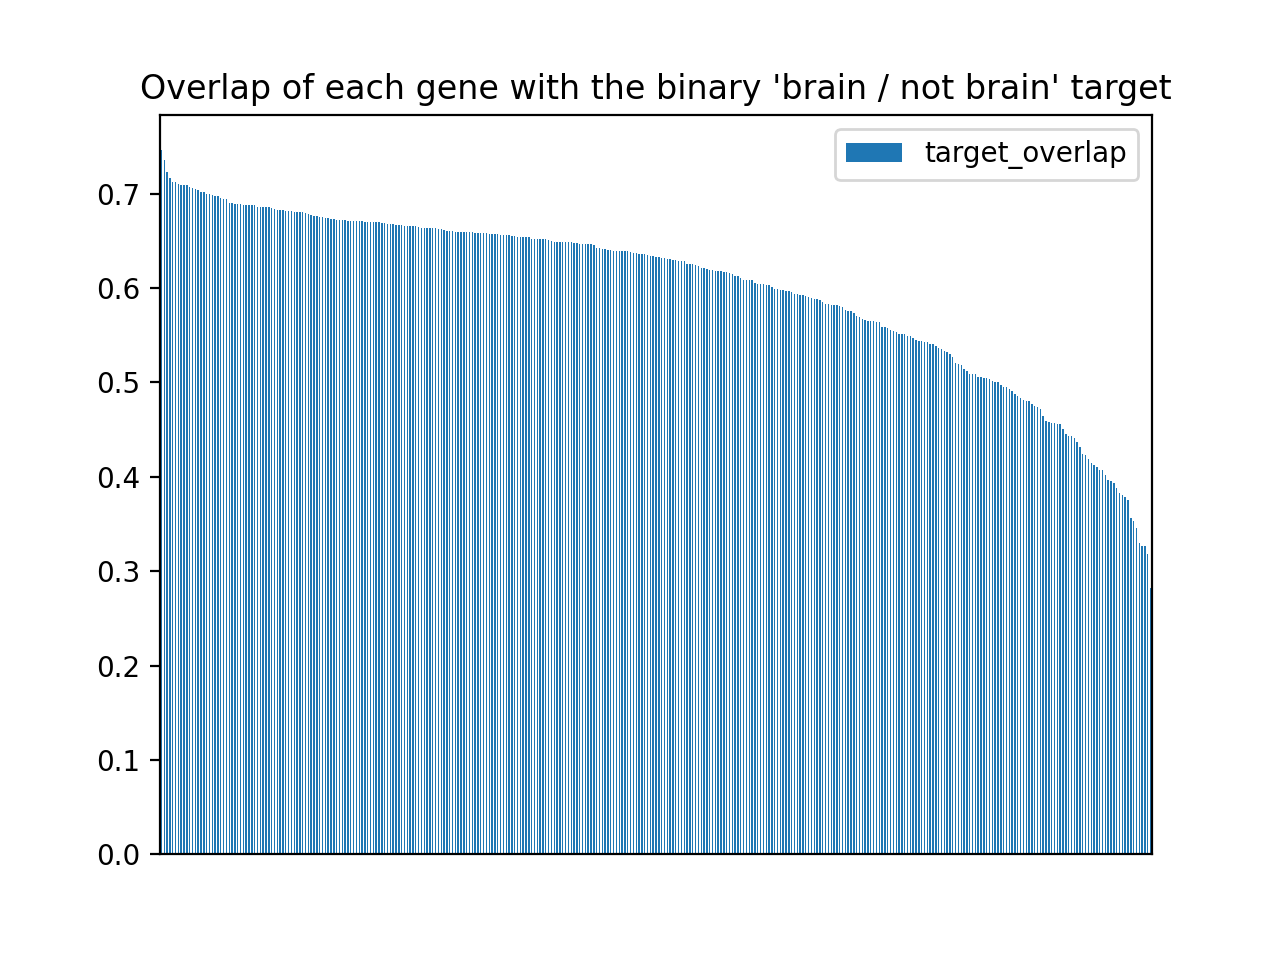

In [12]:
col_target_expl = []
for col in frame.columns:
    col_target_expl.append(((frame[col] > 0).astype(float) == target).sum() / len(frame))
df = pd.DataFrame(
    [frame.columns, col_target_expl], index=["cols", "target_overlap"]
).T.sort_values(by="target_overlap", ascending=False)

df.plot.bar(title="Overlap of each gene with the binary 'brain / not brain' target")
plt.xticks([])
plt.show()

==> Seems like this classification is just an easy task

In [13]:
np.unique(target, return_counts=True)

(array([0, 1]), array([14067,  3704], dtype=int64))

### Build pytorch tensors

In [14]:
# Make holdout test set
# df, df_test are pd.frames, labels are np.arrays
df, df_test, labels, labels_test = train_test_split(frame, target, test_size=0.2, random_state=42, stratify=target)
_, val_counts_test = np.unique(labels_test, return_counts=True)
_, val_counts_rest = np.unique(labels, return_counts=True)
f"Percentage of class 1 in test: {val_counts_test[1]/len(labels_test)}, rest: {val_counts_rest[1]/len(labels)}"


'Percentage of class 1 in test: 0.20843881856540084, rest: 0.20842712436691052'

In [15]:
# Make validation set
df_train, df_val, labels_train, labels_val = train_test_split(df, labels, test_size=0.1, stratify=labels)
# Convert arrays to tensors
X_train = torch.tensor(df_train.values, dtype=torch.float32)
X_val = torch.tensor(df_val.values, dtype=torch.float32)
y_train = torch.tensor(labels_train, dtype=torch.float32).unsqueeze(1)
y_val = torch.tensor(labels_val, dtype=torch.float32).unsqueeze(1)

In [16]:
batch_size = 32
# Create Tensor datasets
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

### Define and train the model

In [17]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.output(x))
        return x

model = BinaryClassifier()


In [18]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)

epochs = 20
accuracies = []
losses = []
for epoch in (pbar := tqdm(range(epochs))):
    model.train()
    for data, targets in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
    # Do validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in val_loader:
            output = model(data)
            predicted = (output > 0.5).float()
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = correct / total
    accuracies.append(accuracy)
    losses.append(loss.item())
    pbar.set_description(f"Epoch {epoch+1}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%")

Epoch 20, Loss: 1.6671588127792347e-06, Accuracy: 98.31%: 100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


c:\Users\1jako\anaconda3\envs\transcriptomics\lib\site-packages\plotnine\utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
c:\Users\1jako\anaconda3\envs\transcriptomics\lib\site-packages\plotnine\geoms\geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


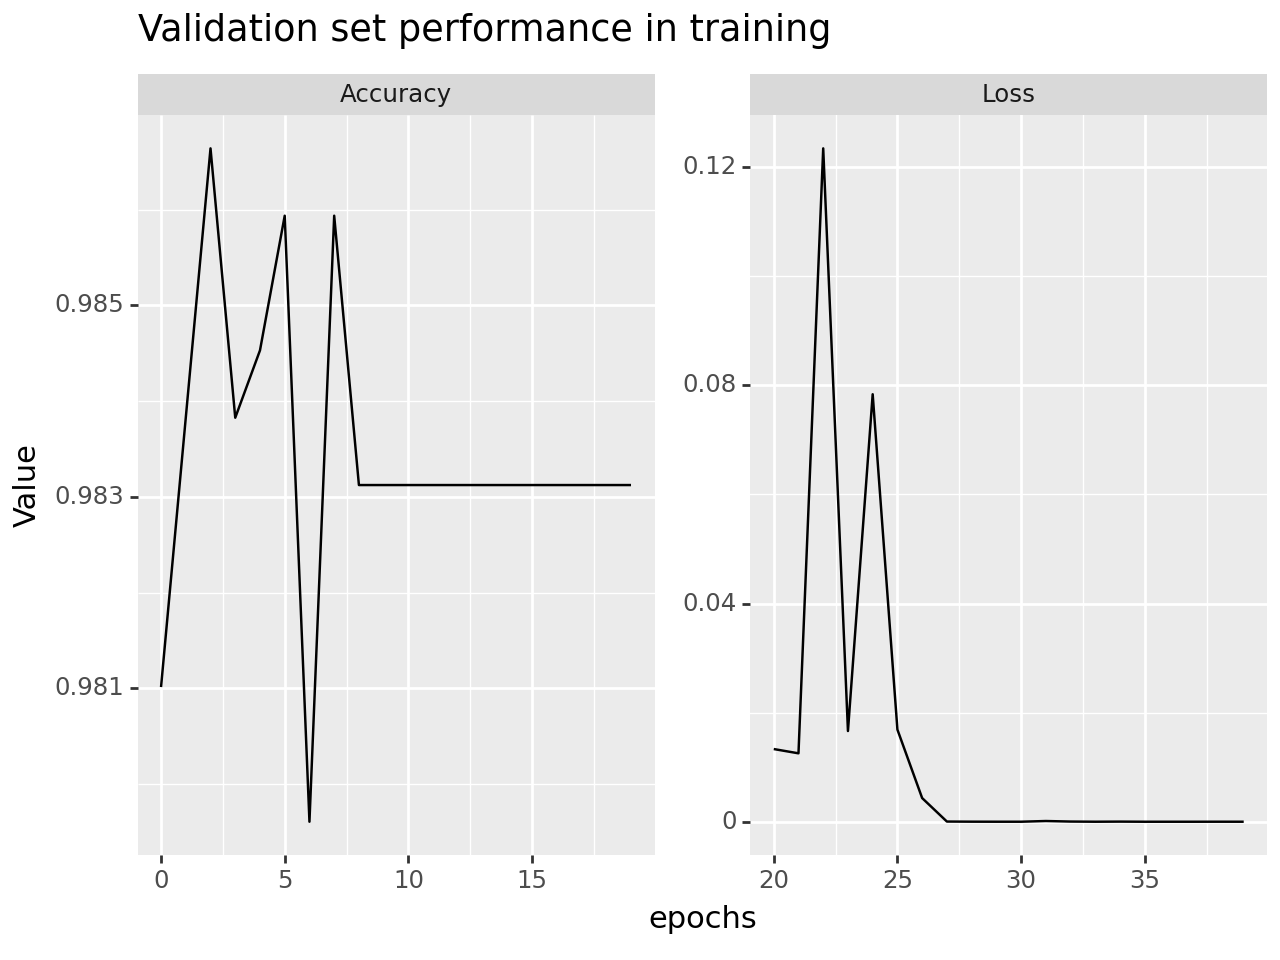

In [19]:
plot_df = pd.DataFrame([accuracies, losses], index=["Accuracy", "Loss"], columns=list(range(epochs))).T
plot_df = plot_df.melt(var_name="Performance_Measure", value_name="Value").reset_index(names="epochs")
plot = (
    ggplot(plot_df, aes(x="epochs", y="Value"))
    + geom_line(plot_df)
    + facet_wrap('Performance_Measure', scales="free")
    + ggtitle("Validation set performance in training")
)
print(plot)

## Test on holdout

In [20]:
X_test = torch.tensor(df_test.values, dtype=torch.float32)
y_test = torch.tensor(labels_test, dtype=torch.float32).unsqueeze(1)
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [21]:
y_pred = []
with torch.no_grad():
        for data, targets in test_loader:
            output = model(data)
            predicted = (output > 0.5).float()
            y_pred.append(predicted)

In [22]:
y_pred = np.concatenate([seg.numpy().flatten() for seg in y_pred])
df_test.shape, y_pred.shape

((3555, 351), (3555,))

In [23]:
test_frame_with_preds = df_test.assign(target = labels_test).assign(predictions = y_pred)
test_frame_with_preds

,Abcc4,Acp5,Acvr1,Acvr2a,Adora2b,Afp,Ahnak,Akr1c19,Alas2,Aldh1a2,...,Wnt3a,Wnt5a,Wnt5b,Wnt8a,Xist,Zfp444,Zfp57,Zic3,target,predictions
embryo1_Pos0_cell183_z5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,2.0,0.0,0,0.0
embryo1_Pos24_cell179_z2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0,0.0
embryo1_Pos8_cell108_z2,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0
embryo1_Pos6_cell238_z5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,1.0,0.0,3.0,0.0,7.0,2.0,10.0,0.0,0,0.0
embryo1_Pos18_cell221_z5,3.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
embryo1_Pos18_cell145_z5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0
embryo1_Pos4_cell356_z5,2.0,0.0,2.0,1.0,1.0,5.0,3.0,3.0,0.0,1.0,...,2.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,1,1.0
embryo1_Pos19_cell96_z5,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0
embryo1_Pos12_cell225_z2,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,6.0,3.0,0.0,0.0,0,0.0


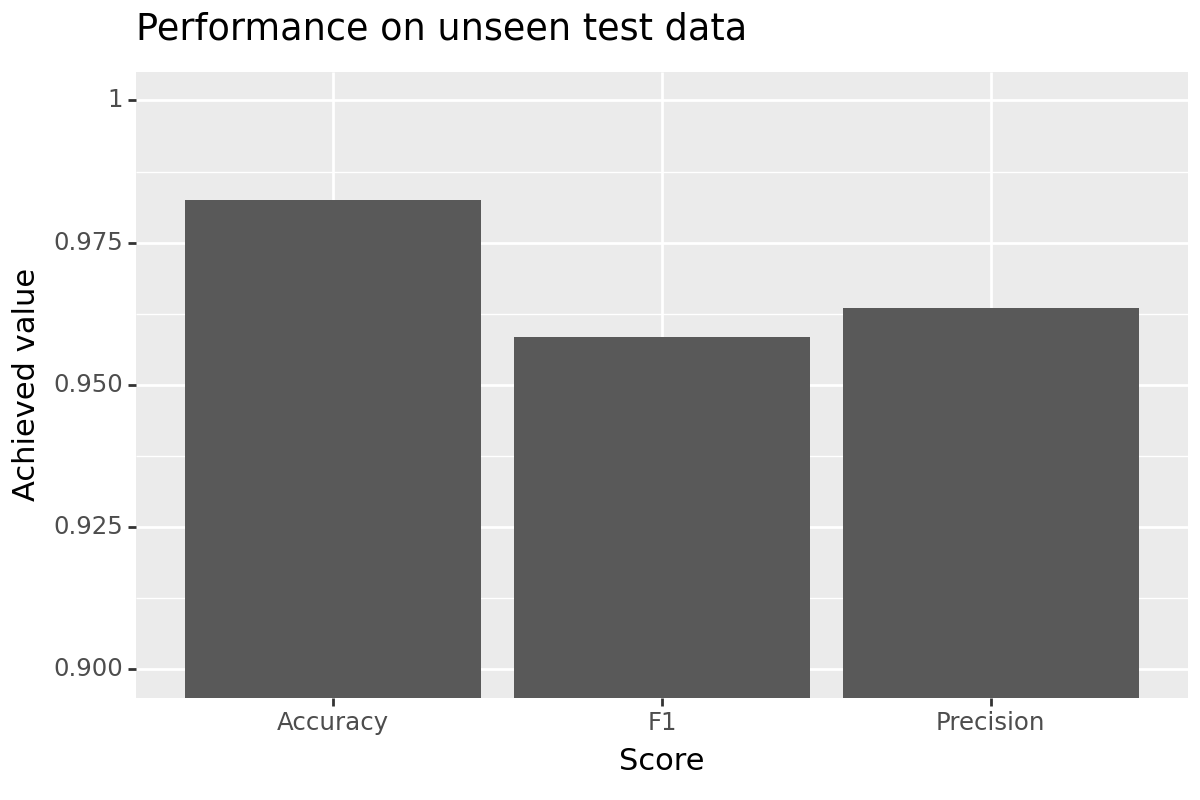

In [56]:
f1 = f1_score(y_pred, labels_test)
prec = precision_score(y_pred, labels_test)
acc = accuracy_score(y_pred, labels_test)
plot_df = pd.DataFrame([["F1", "Precision", "Accuracy"], [f1, prec, acc]], index=["score", "value"]).T
plot_df["value"] = plot_df["value"].astype(float)
plot_df["score"] = pd.Categorical(plot_df["score"])

plot = (
    ggplot(plot_df, aes(x="score", y="value")) 
    + geom_bar(stat="identity")
    + ggtitle("Performance on unseen test data")
    + xlab("Score")
    + ylab("Achieved value")
    + coord_cartesian(ylim=(0.9, 1))
    + theme(figure_size=(6,4))
)
print(plot)

In [47]:
plot_df

,score,value
0,F1,0.958389
1,Precision,0.963563
2,Accuracy,0.98256
